Gamma Ray Image Cleanig

In [1]:
import importlib
import helper
importlib.reload(helper)
dir(helper)

['List',
 'ShowerAnalysisResult',
 'Tuple',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze_shower',
 'apply_thresholds_to_dataset',
 'curve_fit',
 'dataclass',
 'fit_gaussian_to_events',
 'gaussian',
 'hello',
 'np',
 'plot_pixel_matrix',
 'plot_pixel_matrix_with_cg',
 'plot_single_event_gaussian',
 'plot_single_event_histogram',
 'plt',
 'process_event_batch_with_suppression',
 'reshape_to_event_matrices']

# Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

1. Loading of data

In [3]:
gamma_data = np.loadtxt('gamma_0001_0050.txt')
proton_data = np.loadtxt('proton_0001_0300.txt')

In [4]:
print(gamma_data.shape)
print(proton_data.shape)

(2248704, 17)
(2687824, 17)


In [5]:
gamma_event_data = helper.reshape_to_event_matrices(gamma_data)
proton_event_data = helper.reshape_to_event_matrices(proton_data)

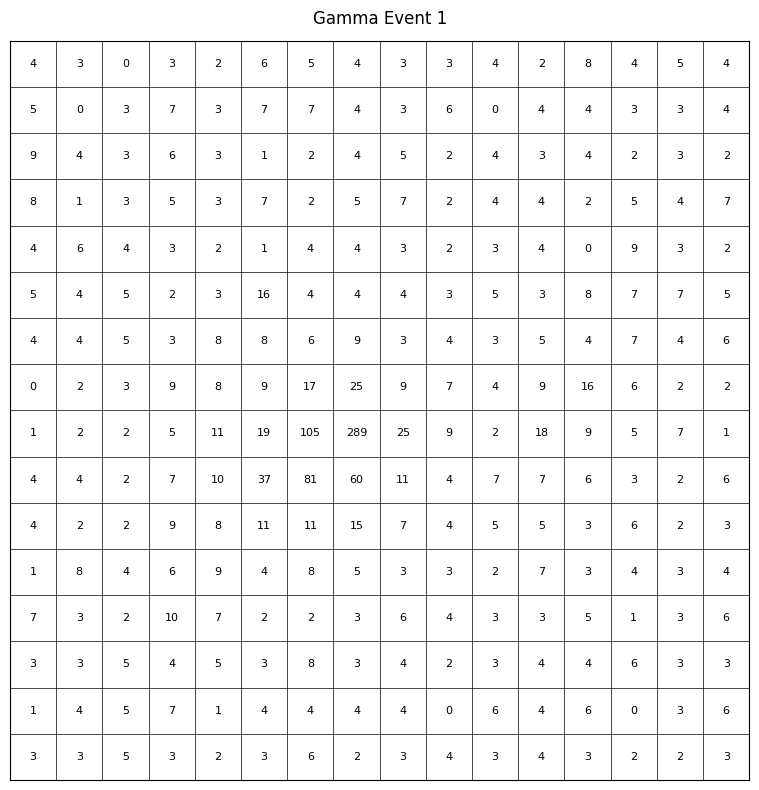

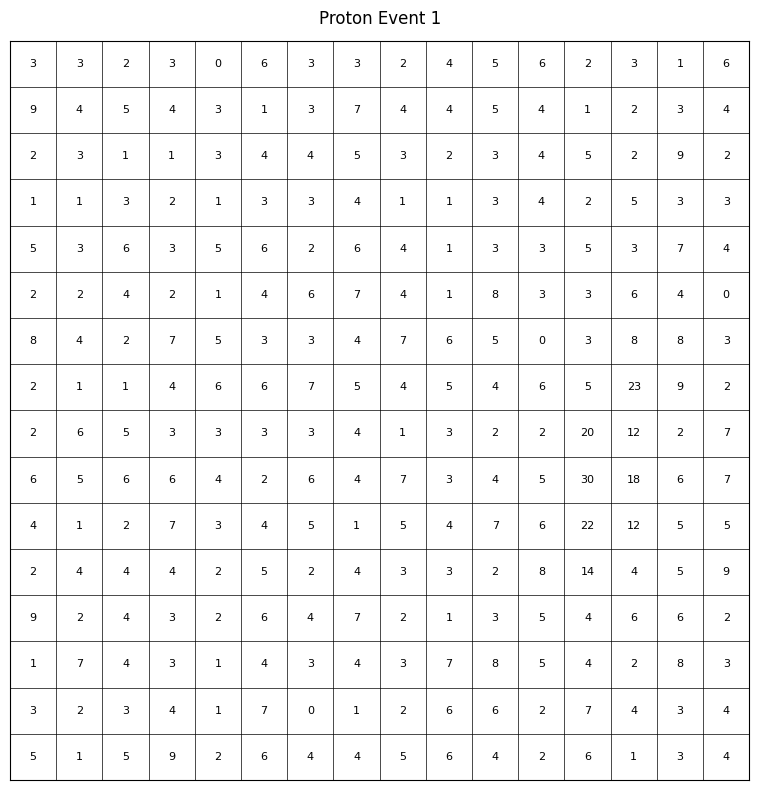

In [6]:
helper.plot_pixel_matrix(gamma_event_data[0], 'Gamma Event 1', show_zeros=True)
helper.plot_pixel_matrix(proton_event_data[0], 'Proton Event 1', show_zeros=True)

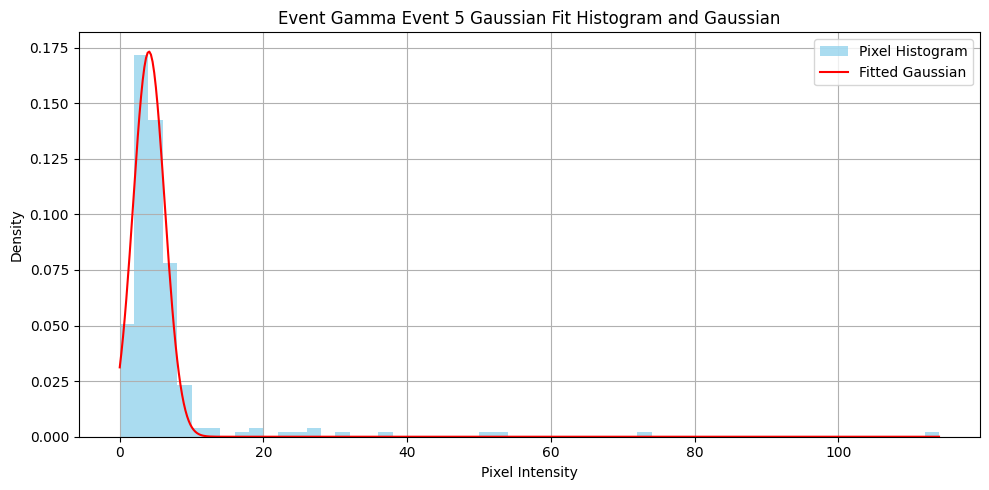

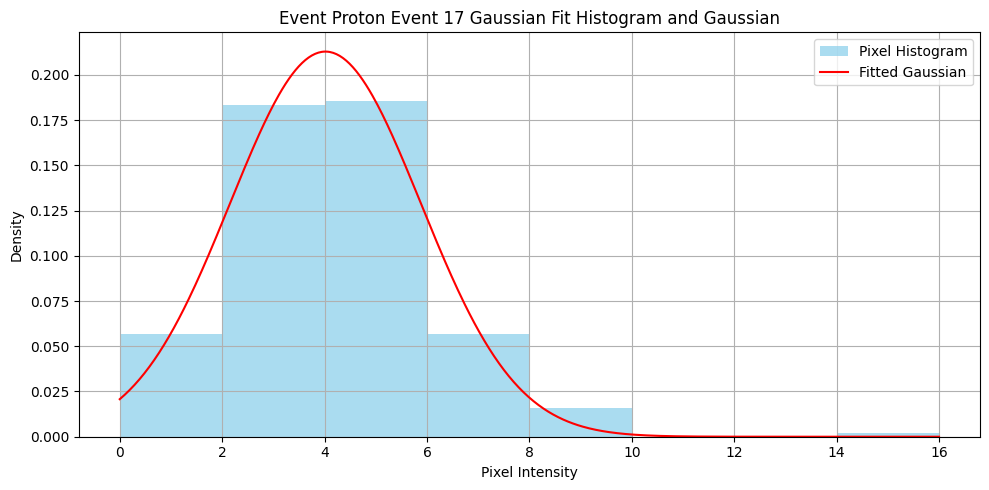

In [7]:
gamma_amplitudes, gamma_means, gamma_stds = helper.fit_gaussian_to_events(gamma_event_data)
proton_amplitudes, proton_means, proton_stds = helper.fit_gaussian_to_events(proton_event_data)
helper.plot_single_event_gaussian(gamma_event_data[4], gamma_amplitudes[4], gamma_means[4], gamma_stds[4], 'Gamma Event 5 Gaussian Fit')
helper.plot_single_event_gaussian(proton_event_data[18], proton_amplitudes[18], proton_means[18], proton_stds[18], 'Proton Event 17 Gaussian Fit')

In [8]:
gamma_bt_list, gamma_pt_list = helper.apply_thresholds_to_dataset(
    gamma_event_data, gamma_means, gamma_stds
)

proton_bt_list, proton_pt_list = helper.apply_thresholds_to_dataset(
    proton_event_data, proton_means, proton_stds
)


In [9]:
gamma_bt_list.shape, gamma_pt_list.shape, proton_bt_list.shape, proton_pt_list.shape

((140544, 16, 16), (140544, 16, 16), (167989, 16, 16), (167989, 16, 16))

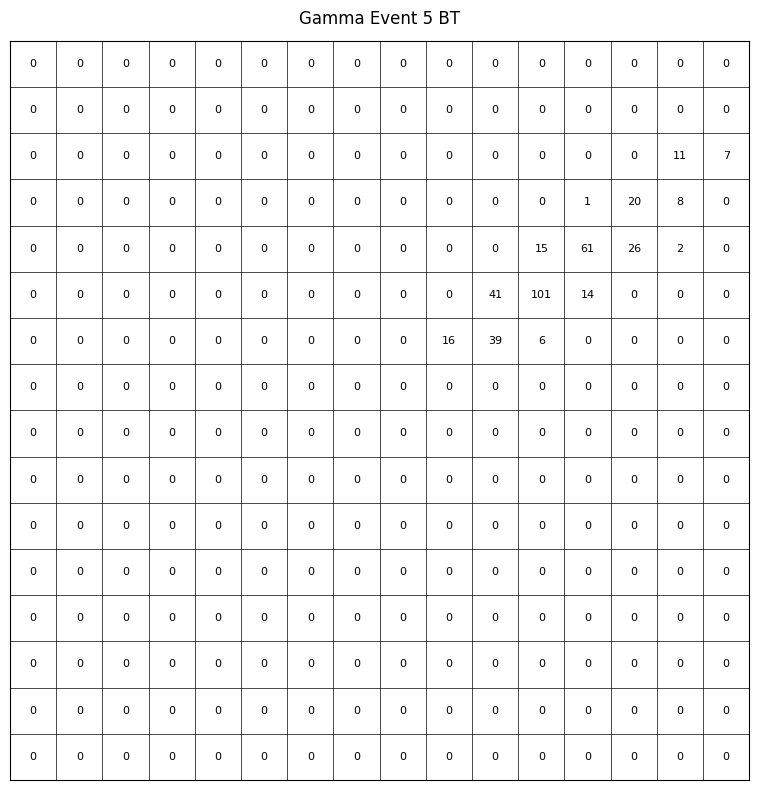

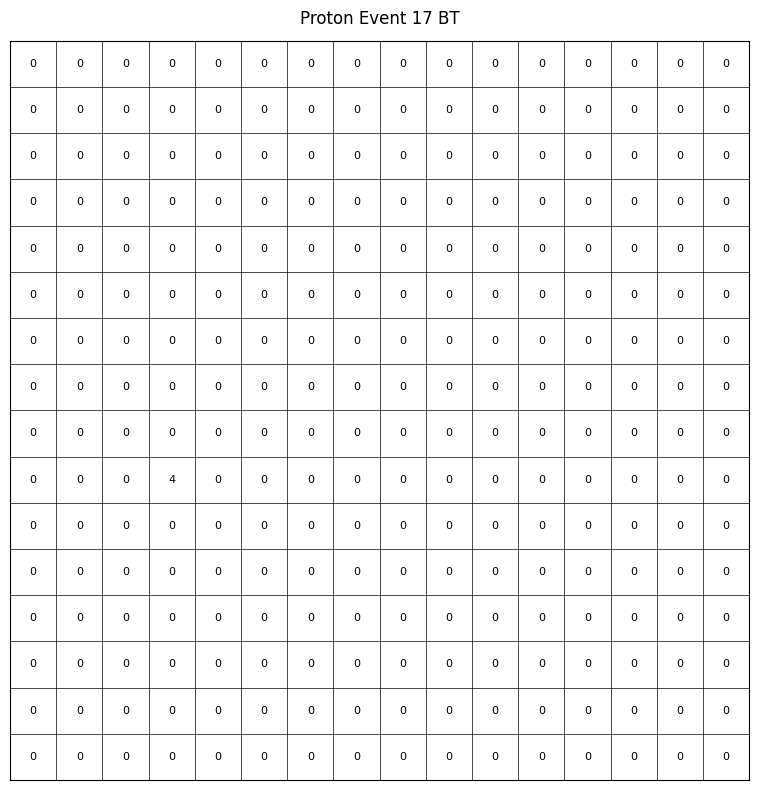

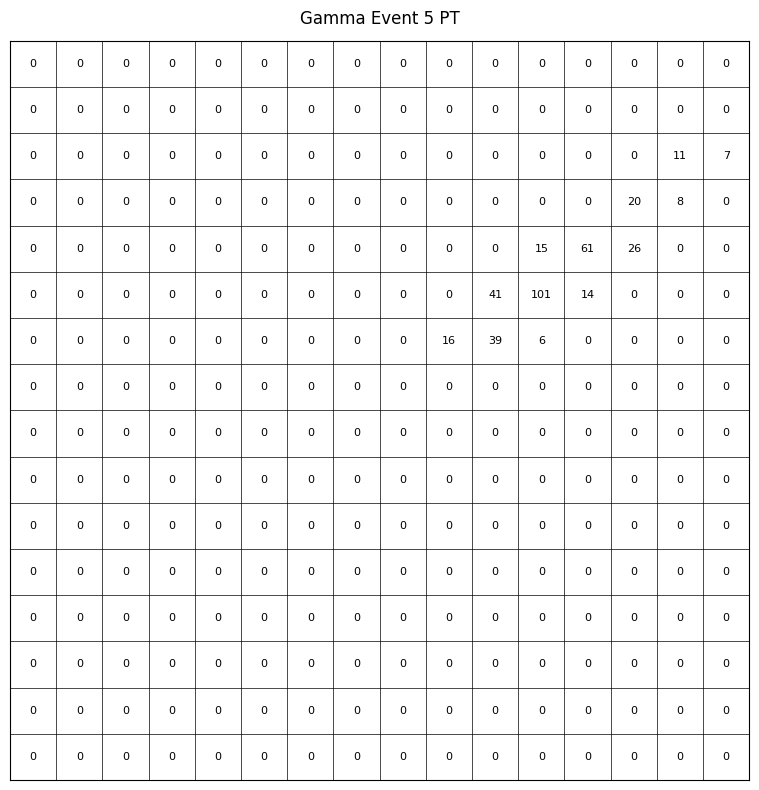

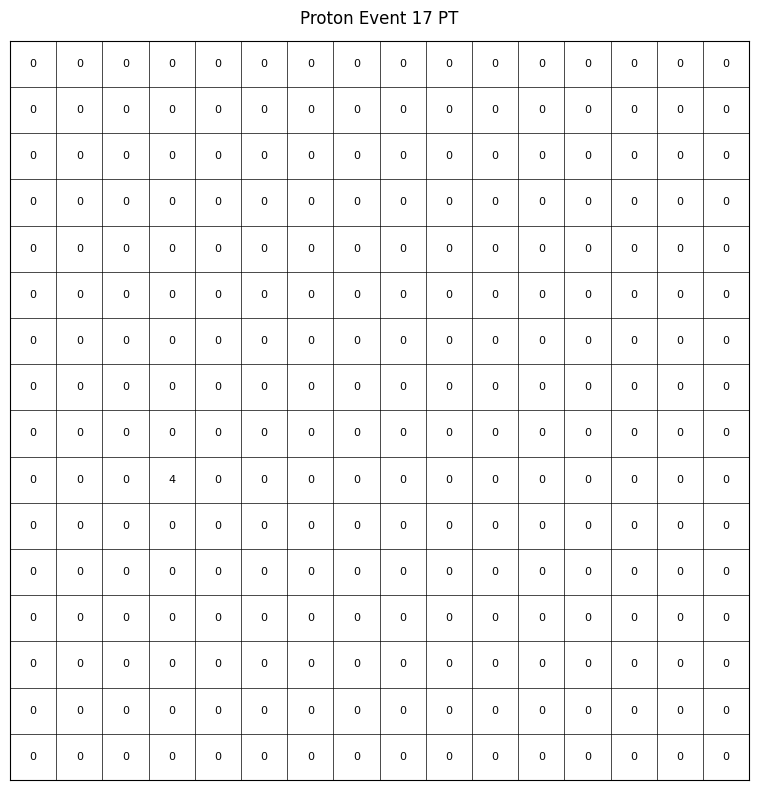

In [10]:
helper.plot_pixel_matrix(gamma_bt_list[4], 'Gamma Event 5 BT', show_zeros=True)
helper.plot_pixel_matrix(proton_bt_list[18], 'Proton Event 17 BT', show_zeros=True)
helper.plot_pixel_matrix(gamma_pt_list[4], 'Gamma Event 5 PT', show_zeros=True)
helper.plot_pixel_matrix(proton_pt_list[18], 'Proton Event 17 PT', show_zeros=True)

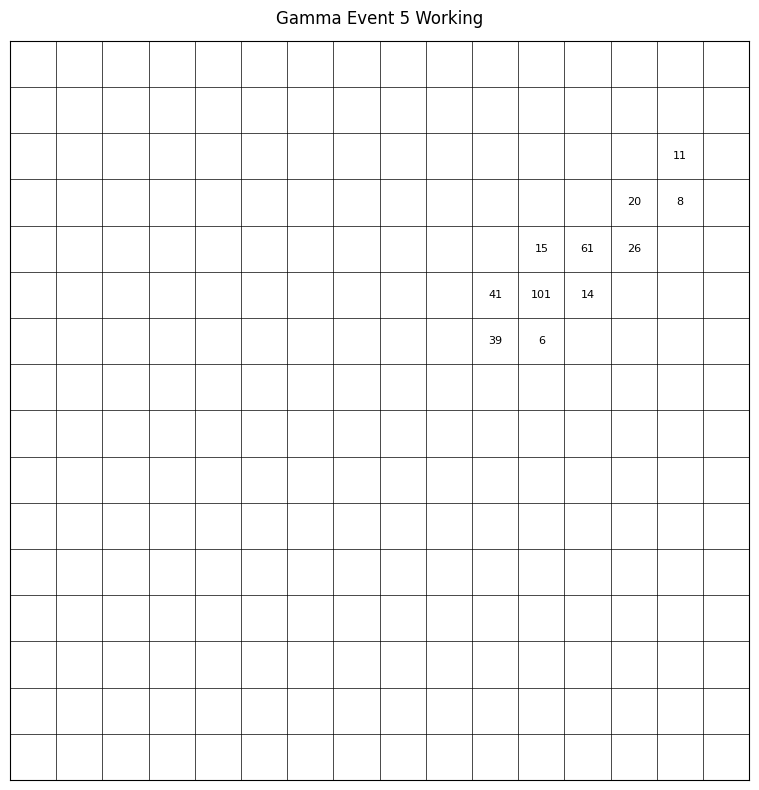

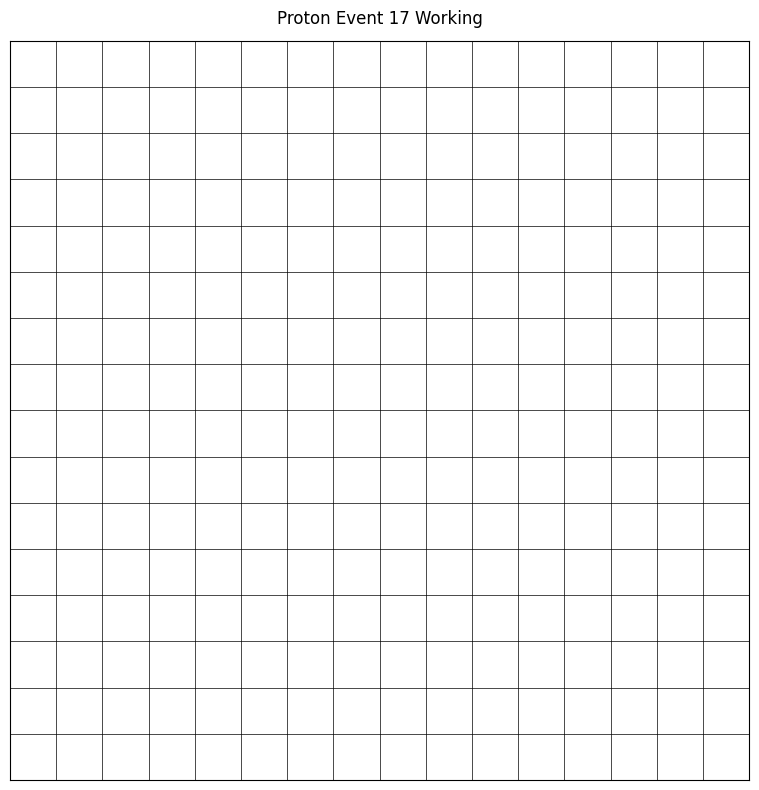

In [11]:
gamma_working = helper.process_event_batch_with_suppression(
    gamma_event_data, gamma_amplitudes, gamma_means, gamma_stds
)

proton_working = helper.process_event_batch_with_suppression(
    proton_event_data, proton_amplitudes, proton_means, proton_stds
)
helper.plot_pixel_matrix(gamma_working[4], 'Gamma Event 5 Working')
helper.plot_pixel_matrix(proton_working[18], 'Proton Event 17 Working')


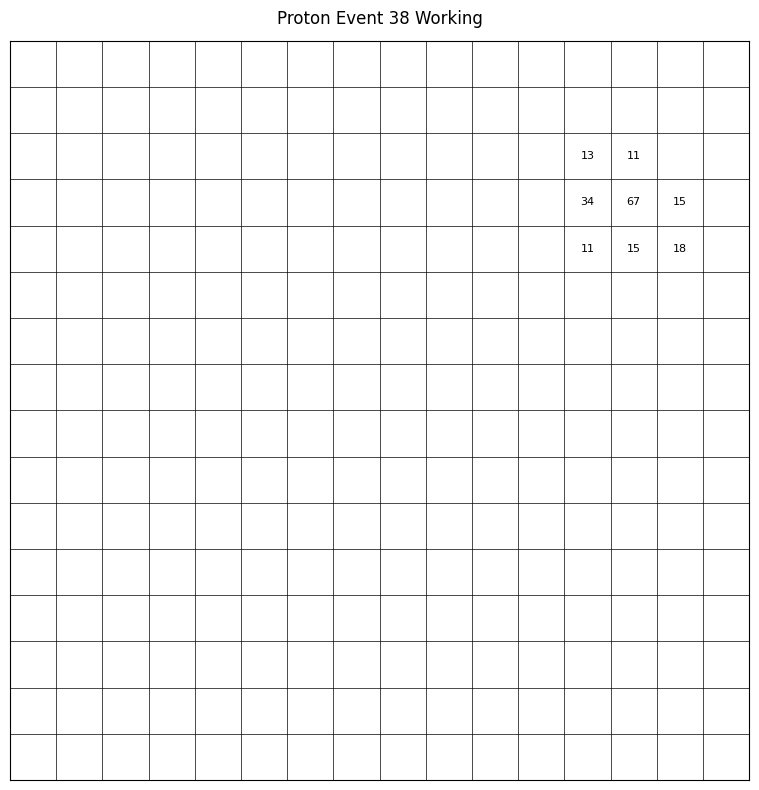

In [12]:
helper.plot_pixel_matrix(proton_working[37], 'Proton Event 38 Working')

In [16]:
import pandas as pd
from dataclasses import asdict
# Analyze gamma events
# and handle exceptions for no detectable signal
gamma_results = []
for shower_matrix in gamma_working:
    try:
        analysis = helper.analyze_shower(shower_matrix, generate_visualization=False)
        gamma_results.append(asdict(analysis))
    except ValueError as e:
        if "no detectable signal" in str(e):
            gamma_results.append({
                'centroid_position': (np.nan, np.nan),
                'longitudinal_extension': np.nan,
                'transverse_extension': np.nan,
                'orientation_angle_degrees_delta': np.nan,
                'elliptical_eccentricity': np.nan,
                'edge_leakage_ratio': np.nan,
                'axis_miss_distance': np.nan,
                'azimuthal_spread': np.nan,
                'distribution_asymmetry': np.nan,
                'radial_displacement': np.nan,
                'radial_orientation_angle': np.nan,
                'invalid_signal': True  # Flag for filtering
            })
        else:
            raise

gamma_df = pd.DataFrame(gamma_results)


/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/helper.py:484: RuntimeWarning: invalid value encountered in scalar divide
  radial_orientation_angle = 90.0 if denom == 0 else np.degrees(np.arctan(abs((axis_slope - radial_slope) / denom)))
/home/abhimanyu/projects/Gapd_camera_gamma_ray_detection/helper.py:483: RuntimeWarning: invalid value encountered in scalar multiply
  denom = 1 + radial_slope * axis_slope


In [17]:
gamma_df

,centroid_position,longitudinal_extension,transverse_extension,orientation_angle_degrees_delta,elliptical_eccentricity,edge_leakage_ratio,axis_miss_distance,azimuthal_spread,distribution_asymmetry,radial_displacement,radial_orientation_angle,invalid_signal
0,"(-0.9402485003236588, -0.7285122618277005)",0.664447,0.431157,59.140034,0.760876,0.0,0.143080,0.468869,0.992869,1.189453,21.371215,NaN
1,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,"(2.028630581484982, 0.8997929648025627)",0.583608,0.385409,46.376067,0.750922,0.0,0.748251,0.420195,0.554134,2.219227,22.456531,NaN
4,"(3.926680765975535, 2.930364523721326)",1.435498,0.367879,51.771525,0.966604,0.0,0.127879,0.514740,0.768764,4.899577,15.038645,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
140539,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
140540,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
140541,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
140542,"(nan, nan)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [18]:
gamma_df.to_csv('particle_shower_analysis.csv', index=False)


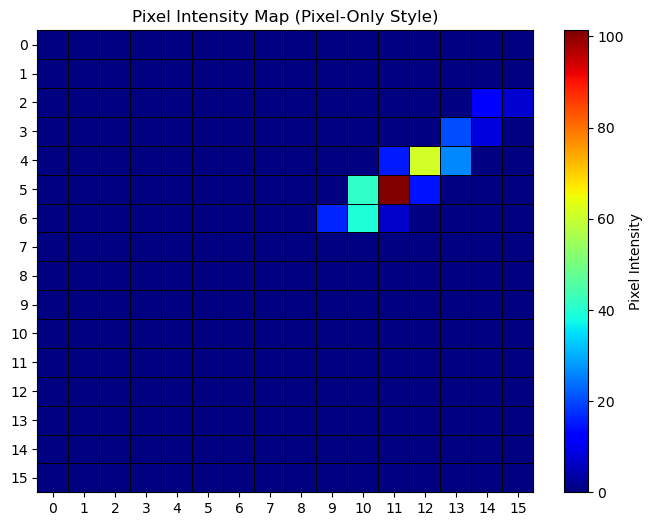

In [20]:
import numpy as np
import matplotlib.pyplot as plt



rows, cols = step2_pixels.shape
x = np.arange(cols + 1)
y = np.arange(rows + 1)

plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, step2_pixels, cmap='jet', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Pixel Intensity")

# Set ticks in center of each pixel
plt.xticks(np.arange(cols) + 0.5, np.arange(cols))
plt.yticks(np.arange(rows) + 0.5, np.arange(rows))
plt.gca().invert_yaxis()

plt.title("Pixel Intensity Map (Pixel-Only Style)")
plt.grid(False)
plt.show()


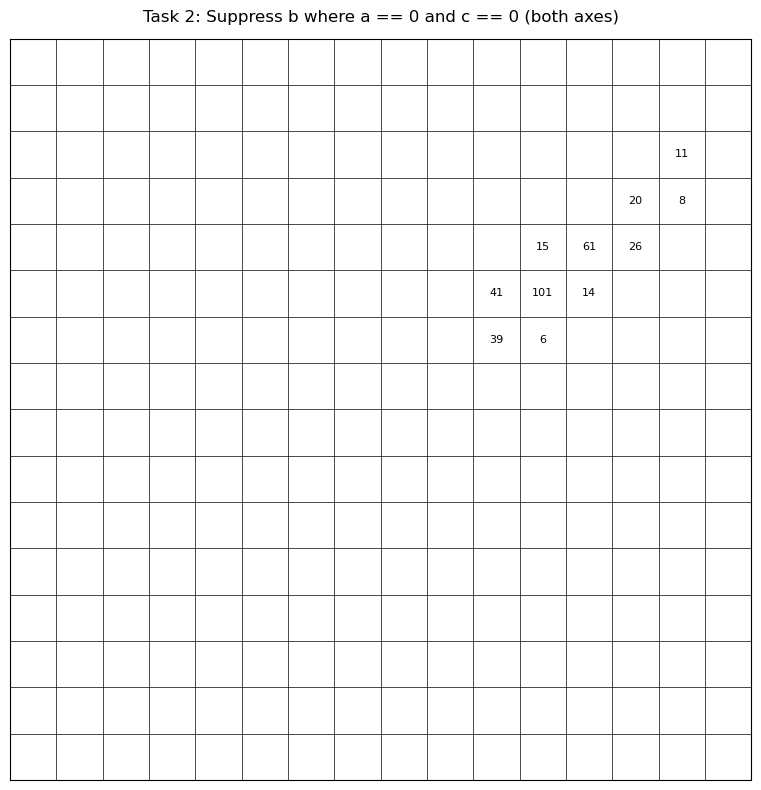

In [57]:
task2_pixels = step2_pixels.copy()

# Horizontal check (as you already have)
for i in range(16):
    for j in range(1, 15):  # skip edges
        a = task2_pixels[i, j - 1]
        b = task2_pixels[i, j]
        c = task2_pixels[i, j + 1]
        if a == 0 and c == 0:
            task2_pixels[i, j] = 0

# Vertical check (new)
for i in range(1, 15):  # skip edges
    for j in range(16):
        a = task2_pixels[i - 1, j]
        b = task2_pixels[i, j]
        c = task2_pixels[i + 1, j]
        if a == 0 and c == 0:
            task2_pixels[i, j] = 0

# Plot the result
plot_pixel_matrix(task2_pixels, "Task 2: Suppress b where a == 0 and c == 0 (both axes)")



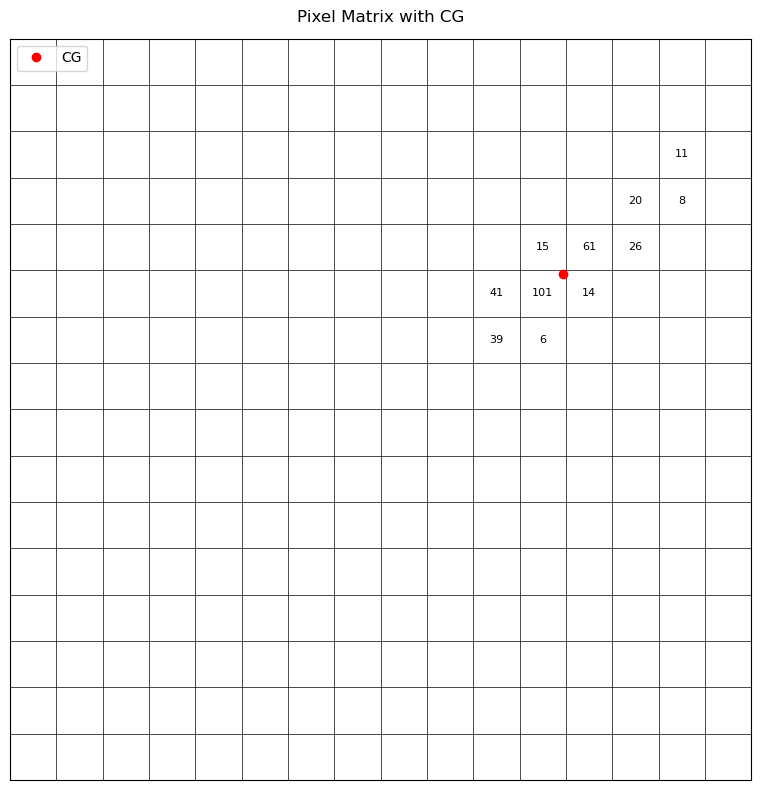

Center of Gravity (x_cg, y_cg): (11.43, 4.57)


In [59]:
# Assuming 'step2_pixels' is a 16x16 NumPy array
plot_pixel_matrix_with_cg(task2_pixels, "Pixel Matrix with CG")


Pixel Data Shape: (140544, 16, 16)
Metadata Shape: (140544, 3)
Metadata for Event 0: [4.20642467 2.07903287 0.17568037]


In [ ]:
from typing import Tuple
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class ShowerAnalysisResult:
    centroid_position: Tuple[float, float]
    longitudinal_extension: float
    transverse_extension: float
    orientation_angle_degrees_delta: float
    elliptical_eccentricity: float
    edge_leakage_ratio: float
    axis_miss_distance: float
    azimuthal_spread: float
    distribution_asymmetry: float
    radial_displacement: float
    radial_orientation_angle: float

def analyze_shower(
    photon_electron_matrix: np.ndarray,
    x_positions: np.ndarray = None,
    y_positions: np.ndarray = None,
    generate_visualization: bool = True
) -> ShowerAnalysisResult:
    
    # Center coordinates at sensor origin
    if x_positions is None:
        sensor_center_x = (photon_electron_matrix.shape[1] - 1) / 2
        x_positions = np.arange(photon_electron_matrix.shape[1]) - sensor_center_x
    if y_positions is None:
        sensor_center_y = (photon_electron_matrix.shape[0] - 1) / 2
        y_positions = sensor_center_y - np.arange(photon_electron_matrix.shape[0])

    total_photon_electrons = np.sum(photon_electron_matrix)
    if total_photon_electrons == 0:
        raise ValueError("Photon-electron matrix contains no detectable signal")

    # Calculate edge leakage
    left_edge_sum = np.sum(photon_electron_matrix[:, 0])
    right_edge_sum = np.sum(photon_electron_matrix[:, -1])
    top_edge_sum = np.sum(photon_electron_matrix[0, :])
    bottom_edge_sum = np.sum(photon_electron_matrix[-1, :])
    total_edge_leakage = left_edge_sum + right_edge_sum + top_edge_sum + bottom_edge_sum
    edge_leakage_ratio = total_edge_leakage / total_photon_electrons

    # Create coordinate grids
    x_grid, y_grid = np.meshgrid(x_positions, y_positions, indexing='xy')

    # Calculate centroid position
    centroid_x = np.sum(photon_electron_matrix * x_grid) / total_photon_electrons
    centroid_y = np.sum(photon_electron_matrix * y_grid) / total_photon_electrons

    # Compute second moments
    second_moment_xx = np.sum(photon_electron_matrix * x_grid**2) / total_photon_electrons - centroid_x**2
    second_moment_yy = np.sum(photon_electron_matrix * y_grid**2) / total_photon_electrons - centroid_y**2
    cross_moment_xy = np.sum(photon_electron_matrix * x_grid * y_grid) / total_photon_electrons - centroid_x * centroid_y

    moment_difference = second_moment_yy - second_moment_xx
    orientation_angle_radians = 0.5 * np.arctan2(2 * cross_moment_xy, moment_difference)
    orientation_angle_degrees_delta = np.degrees(orientation_angle_radians)
    if orientation_angle_degrees_delta < 0:
        orientation_angle_degrees_delta += 180

    # Calculate principal axes
    moment_combination = np.sqrt(moment_difference**2 + 4 * cross_moment_xy**2)
    longitudinal_extension = np.sqrt((second_moment_xx + second_moment_yy + moment_combination) / 2)
    transverse_extension = np.sqrt(abs((second_moment_xx + second_moment_yy - moment_combination) / 2))

    # Compute elliptical eccentricity
    elliptical_eccentricity = np.sqrt(1 - (transverse_extension / longitudinal_extension)**2) if longitudinal_extension != 0 else 0

    # Calculate miss distance from origin to major axis
    if cross_moment_xy != 0:
        major_axis_slope = (moment_difference + moment_combination) / (2 * cross_moment_xy)
        axis_intercept = centroid_y - major_axis_slope * centroid_x
        axis_miss_distance = abs(axis_intercept) / np.sqrt(1 + major_axis_slope**2)
    else:
        axis_miss_distance = abs(centroid_y)

    # Calculate radial displacement and direction
    radial_displacement = np.sqrt(centroid_x**2 + centroid_y**2)
    radial_angle_degrees = np.degrees(np.arctan2(centroid_y, centroid_x))
    if radial_angle_degrees < 0:
        radial_angle_degrees += 180

    # Compute angular difference between radial vector and shower axis
    if centroid_x == 0:
        radial_slope = 999.0
    else:
        radial_slope = centroid_y / centroid_x
    axis_slope = np.tan(orientation_angle_radians)
    slope_denominator = 1 + axis_slope * radial_slope
    if slope_denominator == 0:
        radial_orientation_angle = 90.0
    else:
        radial_orientation_angle = np.degrees(np.arctan(abs((axis_slope - radial_slope) / slope_denominator)))

    # Calculate azimuthal spread
    azimuthal_spread = np.sqrt(
        (longitudinal_extension * np.sin(np.radians(radial_orientation_angle)))**2 +
        (transverse_extension * np.cos(np.radians(radial_orientation_angle)))**2
    )

    # Compute distribution asymmetry
    third_moment_x = np.sum(photon_electron_matrix * (x_grid - centroid_x)**3)
    third_moment_y = np.sum(photon_electron_matrix * (y_grid - centroid_y)**3)
    raw_asymmetry = (third_moment_x + third_moment_y) / total_photon_electrons
    distribution_asymmetry = abs(raw_asymmetry)**(1/3) / longitudinal_extension if longitudinal_extension != 0 else 0

    if generate_visualization:
        plt.figure(figsize=(10, 8))

        # Create edge coordinates for proper alignment
        x_edges = np.linspace(x_positions[0] - 0.5, x_positions[-1] + 0.5, photon_electron_matrix.shape[1] + 1)
        y_edges = np.linspace(y_positions[0] - 0.5, y_positions[-1] + 0.5, photon_electron_matrix.shape[0] + 1)  # Reverse for correct y-axis orientation
        mesh_plot = plt.pcolormesh(x_edges, y_edges, photon_electron_matrix, 
                       cmap='viridis', edgecolors='black', linewidth=0.5)

        # Create fitted ellipse
        ellipse_major_axis = 1.4 * longitudinal_extension
        ellipse_minor_axis = 1.4 * transverse_extension
        angle_parameterization = np.linspace(0, 2 * np.pi, 200)
        ellipse_x_coordinates = (
            centroid_x + 
            ellipse_major_axis * np.cos(angle_parameterization) * np.cos(orientation_angle_radians) - 
            ellipse_minor_axis * np.sin(angle_parameterization) * np.sin(orientation_angle_radians)
        )
        ellipse_y_coordinates = (
            centroid_y + 
            ellipse_major_axis * np.cos(angle_parameterization) * np.sin(orientation_angle_radians) + 
            ellipse_minor_axis * np.sin(angle_parameterization) * np.cos(orientation_angle_radians)
        )
        plt.plot(ellipse_x_coordinates, ellipse_y_coordinates, 'w-', linewidth=2, label='Fitted Ellipse')

        # Plot centroid and origin connection
        plt.scatter([centroid_x], [centroid_y], color='magenta', edgecolors='black', 
                  label='Energy Centroid', zorder=3)
        plt.plot([0, centroid_x], [0, centroid_y], 'cyan', linestyle='--', 
               linewidth=1.5, label='Center-to-Centroid Vector')
        
        # Plot major axis vector
        orientation_angle_radians = np.radians(orientation_angle_degrees_delta)
        # Extend the major axis vector for visualization
        axis_length = 1.4 * longitudinal_extension
        dx = axis_length * np.cos(orientation_angle_radians)
        dy = axis_length * np.sin(orientation_angle_radians)
        plt.plot(
            [centroid_x - dx, centroid_x + dx],
            [centroid_y - dy, centroid_y + dy],
            color='red', linestyle='-', linewidth=2, label='Major Axis Vector'
        )
        plt.axhline(0, color='gray', linewidth=1, linestyle='--')
        plt.axvline(0, color='gray', linewidth=1, linestyle='--')

        # Configure axes and labels
        plt.xticks(x_positions, rotation=45)
        plt.yticks(y_positions)
        plt.grid(visible=False)
        color_bar = plt.colorbar(mesh_plot)
        color_bar.set_label("Photon-Electron Count")
        plt.title("Particle Shower Profile with Elliptical Approximation", pad=20)
        plt.xlabel("X Position (Sensor Units)")
        plt.ylabel("Y Position (Sensor Units)")
        plt.legend(loc='upper right', framealpha=0.9)
        plt.tight_layout()
        plt.show()

    return ShowerAnalysisResult(
        centroid_position=(centroid_x, centroid_y),
        longitudinal_extension=longitudinal_extension,
        transverse_extension=transverse_extension,
        orientation_angle_degrees_delta=orientation_angle_degrees_delta,
        elliptical_eccentricity=elliptical_eccentricity,
        edge_leakage_ratio=edge_leakage_ratio,
        axis_miss_distance=axis_miss_distance,
        azimuthal_spread=azimuthal_spread,
        distribution_asymmetry=distribution_asymmetry,
        radial_displacement=radial_displacement,
        radial_orientation_angle=radial_orientation_angle
    )


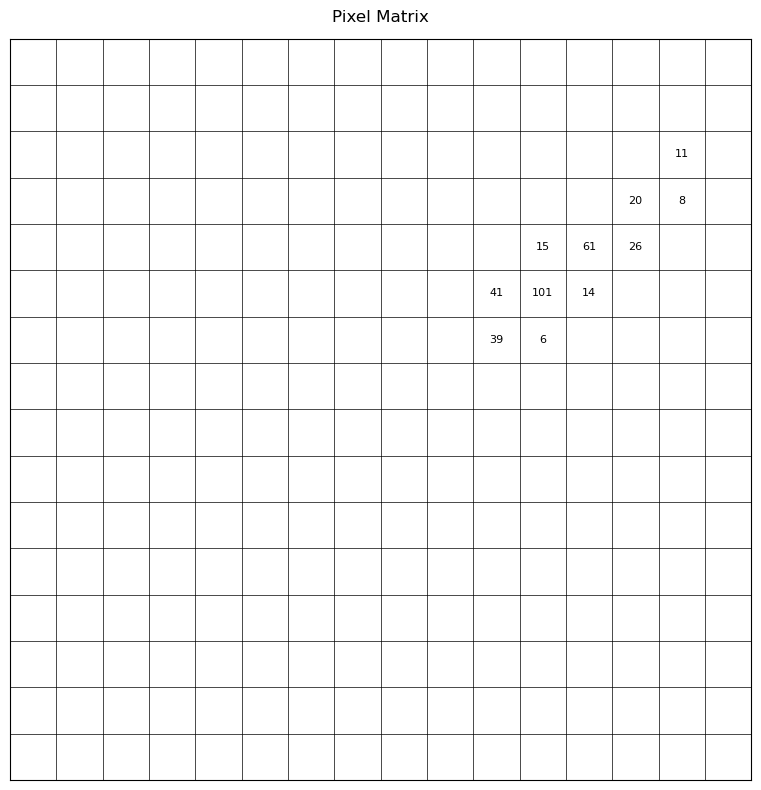

In [63]:
plot_pixel_matrix(task2_pixels, "Pixel Matrix")

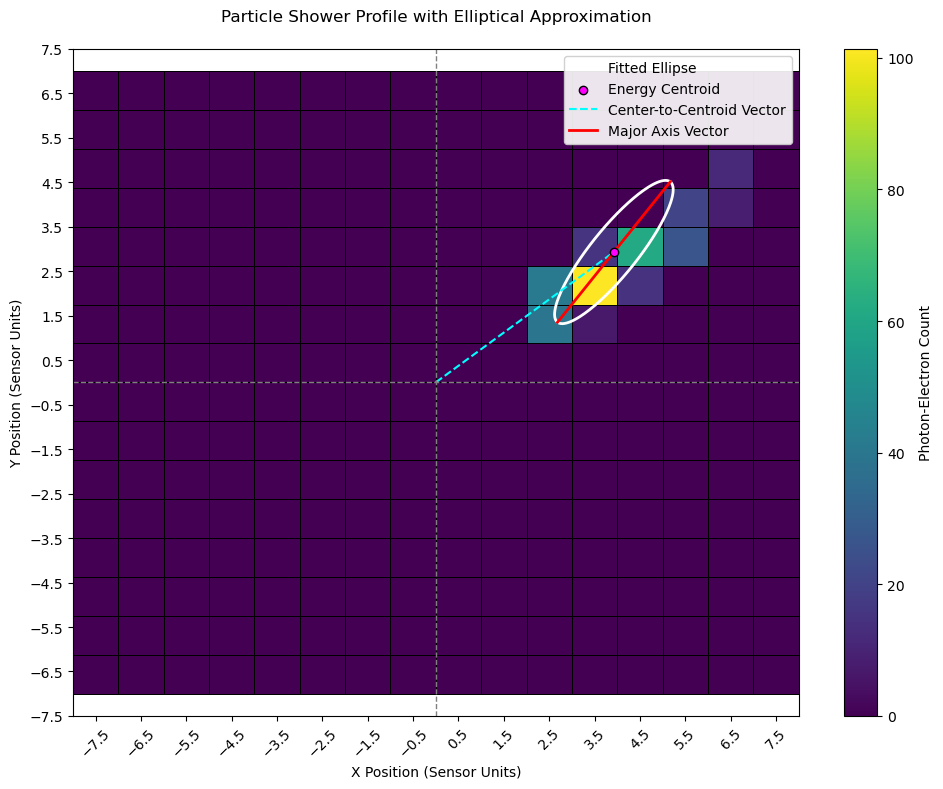

centroid_position: (np.float64(3.926680765975535), np.float64(2.930364523721326))
longitudinal_extension: 1.4355
transverse_extension: 0.3679
orientation_angle_degrees: 51.7715
elliptical_eccentricity: 0.9666
edge_leakage_ratio: 0.0000
axis_miss_distance: 0.1279
azimuthal_spread: 0.5147
distribution_asymmetry: 0.7688
radial_displacement: 4.8996
radial_orientation_angle: 15.0386


In [66]:


from dataclasses import asdict

result = analyze_shower(task2_pixels, generate_visualization=True)


for key, value in asdict(result).items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")



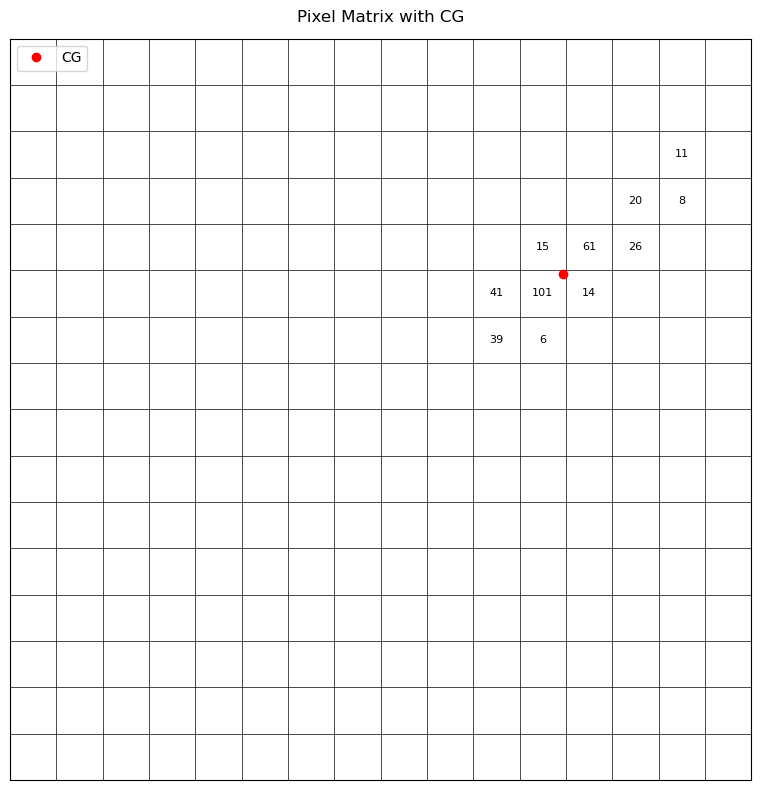

Center of Gravity (x_cg, y_cg): (11.43, 4.57)


In [65]:
plot_pixel_matrix_with_cg(task2_pixels, "Pixel Matrix with CG")

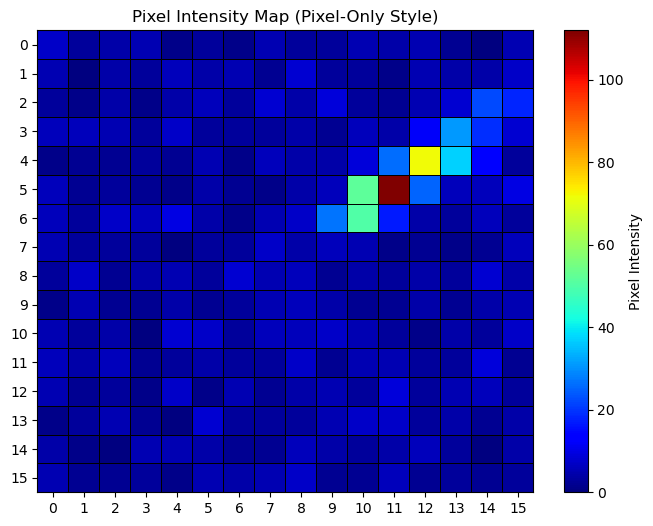

In [37]:
import numpy as np
import matplotlib.pyplot as plt



rows, cols = event_data[4].shape
x = np.arange(cols + 1)
y = np.arange(rows + 1)

plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, event_data[4], cmap='jet', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Pixel Intensity")

# Set ticks in center of each pixel
plt.xticks(np.arange(cols) + 0.5, np.arange(cols))
plt.yticks(np.arange(rows) + 0.5, np.arange(rows))
plt.gca().invert_yaxis()

plt.title("Pixel Intensity Map (Pixel-Only Style)")
plt.grid(False)
plt.show()


In [5]:
import numpy as np
data_proton = np.loadtxt('proton_0001_0300.txt')
print(data)

[[1.000e+00 3.000e+00 3.000e+00 ... 3.000e+00 1.000e+00 6.000e+00]
 [1.000e+00 9.000e+00 4.000e+00 ... 2.000e+00 3.000e+00 4.000e+00]
 [1.000e+00 2.000e+00 3.000e+00 ... 2.000e+00 9.000e+00 2.000e+00]
 ...
 [1.997e+04 2.000e+00 4.000e+00 ... 1.000e+00 4.000e+00 4.000e+00]
 [1.997e+04 1.000e+00 4.000e+00 ... 3.000e+00 8.000e+00 2.000e+00]
 [1.997e+04 3.000e+00 4.000e+00 ... 4.000e+00 1.000e+00 1.000e+00]]


In [8]:
data_proton[0]

array([1., 3., 3., 2., 3., 0., 6., 3., 3., 2., 4., 5., 6., 2., 3., 1., 6.])

In [7]:
proton_event_numbers = data_proton[:, 0]
proton_pixel_data = data_proton[:, 1:]
proton_total_events = len(proton_event_numbers)//16
print(proton_total_events)

167989


In [9]:
data_proton.shape

(2687824, 17)

In [12]:
proton_event_data = proton_pixel_data.reshape(proton_total_events, 16, 16)  # Reshape to (N, 16, 16)

In [13]:
proton_event_data[0]

array([[ 3.,  3.,  2.,  3.,  0.,  6.,  3.,  3.,  2.,  4.,  5.,  6.,  2.,
         3.,  1.,  6.],
       [ 9.,  4.,  5.,  4.,  3.,  1.,  3.,  7.,  4.,  4.,  5.,  4.,  1.,
         2.,  3.,  4.],
       [ 2.,  3.,  1.,  1.,  3.,  4.,  4.,  5.,  3.,  2.,  3.,  4.,  5.,
         2.,  9.,  2.],
       [ 1.,  1.,  3.,  2.,  1.,  3.,  3.,  4.,  1.,  1.,  3.,  4.,  2.,
         5.,  3.,  3.],
       [ 5.,  3.,  6.,  3.,  5.,  6.,  2.,  6.,  4.,  1.,  3.,  3.,  5.,
         3.,  7.,  4.],
       [ 2.,  2.,  4.,  2.,  1.,  4.,  6.,  7.,  4.,  1.,  8.,  3.,  3.,
         6.,  4.,  0.],
       [ 8.,  4.,  2.,  7.,  5.,  3.,  3.,  4.,  7.,  6.,  5.,  0.,  3.,
         8.,  8.,  3.],
       [ 2.,  1.,  1.,  4.,  6.,  6.,  7.,  5.,  4.,  5.,  4.,  6.,  5.,
        23.,  9.,  2.],
       [ 2.,  6.,  5.,  3.,  3.,  3.,  3.,  4.,  1.,  3.,  2.,  2., 20.,
        12.,  2.,  7.],
       [ 6.,  5.,  6.,  6.,  4.,  2.,  6.,  4.,  7.,  3.,  4.,  5., 30.,
        18.,  6.,  7.],
       [ 4.,  1.,  2.,  7.,  3

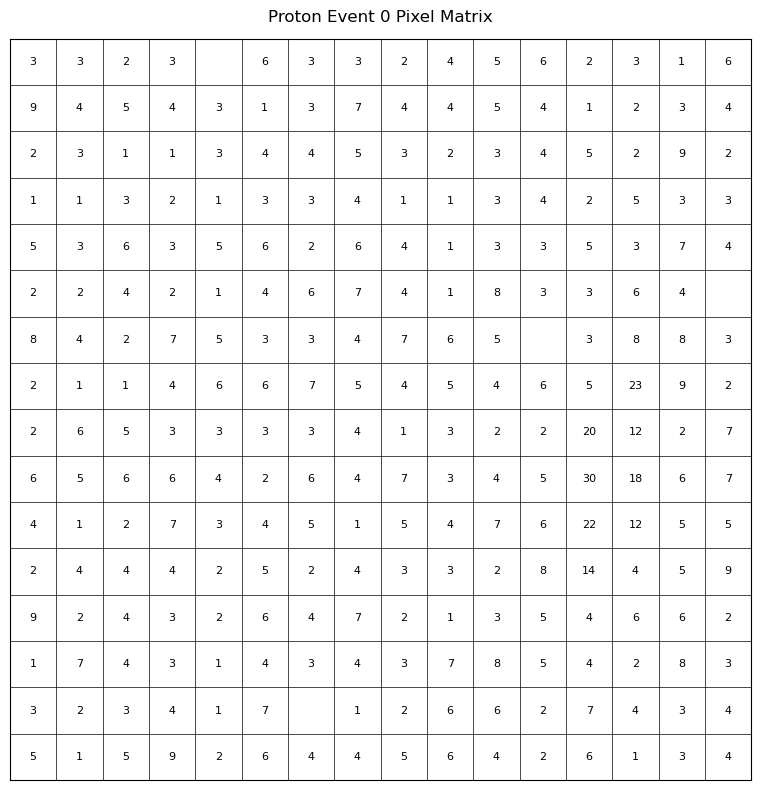

In [17]:
plot_pixel_matrix(proton_event_data[0], "Proton Event 0 Pixel Matrix")